## Sentiment classifier using Vader


In [16]:
from pyspark import SparkContext
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit
from functools import reduce
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud 
import pandas as pd
import re
import string

In [17]:
spark = SparkSession.builder.master('local[*]').config('spark.dirver.maxResultSize', '8g') .config("spark.driver.memory", "20g").appName('AirBnB').getOrCreate()

In [18]:
df = spark.read.csv('Clean_reviews.csv', sep=',', escape='"', header=True, 
               inferSchema=True, multiLine=True)

In [19]:
df.show()
df = df.limit(10000)
type(df)

+----------+-------------------+-----------+--------------------+
|listing_id|               date|reviewer_id|            comments|
+----------+-------------------+-----------+--------------------+
|      2060|2008-09-22 00:00:00|       2865|very nice neighbo...|
|      2595|2009-11-21 00:00:00|      50679|Notre séjour de t...|
|      2595|2009-12-05 00:00:00|      53267|   Great experience.|
|      2595|2009-12-10 00:00:00|      38960|I've stayed with ...|
|      2595|2010-04-09 00:00:00|      71130|We've been stayin...|
|      2595|2010-05-25 00:00:00|     117113|We had a wonderfu...|
|      2595|2012-05-07 00:00:00|    1783688|Hi to everyone!
...|
|      2595|2012-05-17 00:00:00|    1870771|Jennifer was very...|
|      2595|2012-08-18 00:00:00|    2124102|This apartment is...|
|      2595|2013-05-20 00:00:00|     496053|Jennifer's place ...|
|      2595|2014-05-21 00:00:00|   13685934|Jennifer is a ver...|
|      2595|2014-07-10 00:00:00|   10781357|This is a cute st...|
|      2595

pyspark.sql.dataframe.DataFrame

### NLTK Pyspark for reviews classification

In [20]:
reviews_rdd = df.select("comments").rdd.flatMap(lambda x: x)
reviews_rdd.collect()

['very nice neighborhood,close enough to "A" train,\r\ncomfortable bed and clean home over all.\r\nJennys cat is very sweet and fun to play with, but wants to sleep in bed with you and won\'t shut up unless such privilages are granted . . .\r\nMeyow meyow meyow.',
 'Notre séjour de trois nuits.\r\nNous avons apprécier L\'appartement qui est très bien situé. Agréable, propre et bien soigné. C\'est idéal pour une famille de 3 ou 4 personnes.\r\nPetits soucis en arrivant il y avait personne pour nous recevoir, et il manquait le savon pour la douche, le liquide vaisselle, nous les avons reçu de surlendemain. Il y a aussi le bruit du Métro de NY, donc une première nuit difficile si on est pas habitué. Jennifer est correcte le remboursement de la caution était très rapide.  A part ces petits détails notre court séjour c\'est bien passé. \r\nSi j\'ai la possibilité de revenir sur NY pour les vacances, je reprendrai à "The Midtown Castle"\r\nJean\r\nPossession - Ile de La Réunion\r\n',
 'Great

## Convert text into lower case

In [21]:
reviews_rdd_lower = reviews_rdd.map(lambda x: x.lower())
reviews_rdd_lower.collect()

['very nice neighborhood,close enough to "a" train,\r\ncomfortable bed and clean home over all.\r\njennys cat is very sweet and fun to play with, but wants to sleep in bed with you and won\'t shut up unless such privilages are granted . . .\r\nmeyow meyow meyow.',
 'notre séjour de trois nuits.\r\nnous avons apprécier l\'appartement qui est très bien situé. agréable, propre et bien soigné. c\'est idéal pour une famille de 3 ou 4 personnes.\r\npetits soucis en arrivant il y avait personne pour nous recevoir, et il manquait le savon pour la douche, le liquide vaisselle, nous les avons reçu de surlendemain. il y a aussi le bruit du métro de ny, donc une première nuit difficile si on est pas habitué. jennifer est correcte le remboursement de la caution était très rapide.  a part ces petits détails notre court séjour c\'est bien passé. \r\nsi j\'ai la possibilité de revenir sur ny pour les vacances, je reprendrai à "the midtown castle"\r\njean\r\npossession - ile de la réunion\r\n',
 'great

## Sentence Tokenization

In [22]:
reviews_tokenization_rdd = reviews_rdd_lower.map(lambda x: nltk.sent_tokenize(x))
reviews_tokenization_rdd.collect()

[['very nice neighborhood,close enough to "a" train,\r\ncomfortable bed and clean home over all.',
  "jennys cat is very sweet and fun to play with, but wants to sleep in bed with you and won't shut up unless such privilages are granted .",
  '.',
  '.',
  'meyow meyow meyow.'],
 ['notre séjour de trois nuits.',
  "nous avons apprécier l'appartement qui est très bien situé.",
  'agréable, propre et bien soigné.',
  "c'est idéal pour une famille de 3 ou 4 personnes.",
  'petits soucis en arrivant il y avait personne pour nous recevoir, et il manquait le savon pour la douche, le liquide vaisselle, nous les avons reçu de surlendemain.',
  'il y a aussi le bruit du métro de ny, donc une première nuit difficile si on est pas habitué.',
  'jennifer est correcte le remboursement de la caution était très rapide.',
  "a part ces petits détails notre court séjour c'est bien passé.",
  'si j\'ai la possibilité de revenir sur ny pour les vacances, je reprendrai à "the midtown castle"\r\njean\r\npo

## Word Tokenization

In [23]:
def sentTokenizeWord(x):
    splitted = [word for line in x for word in line.split()]
    return splitted

word_tokenize_rdd = reviews_tokenization_rdd.map(sentTokenizeWord)
word_tokenize_rdd.collect()

[['very',
  'nice',
  'neighborhood,close',
  'enough',
  'to',
  '"a"',
  'train,',
  'comfortable',
  'bed',
  'and',
  'clean',
  'home',
  'over',
  'all.',
  'jennys',
  'cat',
  'is',
  'very',
  'sweet',
  'and',
  'fun',
  'to',
  'play',
  'with,',
  'but',
  'wants',
  'to',
  'sleep',
  'in',
  'bed',
  'with',
  'you',
  'and',
  "won't",
  'shut',
  'up',
  'unless',
  'such',
  'privilages',
  'are',
  'granted',
  '.',
  '.',
  '.',
  'meyow',
  'meyow',
  'meyow.'],
 ['notre',
  'séjour',
  'de',
  'trois',
  'nuits.',
  'nous',
  'avons',
  'apprécier',
  "l'appartement",
  'qui',
  'est',
  'très',
  'bien',
  'situé.',
  'agréable,',
  'propre',
  'et',
  'bien',
  'soigné.',
  "c'est",
  'idéal',
  'pour',
  'une',
  'famille',
  'de',
  '3',
  'ou',
  '4',
  'personnes.',
  'petits',
  'soucis',
  'en',
  'arrivant',
  'il',
  'y',
  'avait',
  'personne',
  'pour',
  'nous',
  'recevoir,',
  'et',
  'il',
  'manquait',
  'le',
  'savon',
  'pour',
  'la',
  'douch

## Removing stop words, punctuation and spaces

In [24]:
from nltk.corpus import stopwords

def remove_stop(x):
    stop_words = set(stopwords.words('english'))
    filtered_rdd_stopwords = [word for word in x if not word in stop_words]
    return filtered_rdd_stopwords
def remove_punc(x):
    list_punct=list(string.punctuation)
    filtered = [''.join(c for c in s if c not in list_punct) for s in x] 
    filtered_space = [s for s in filtered if s] #remove empty space 
    return filtered
stp_rmv_rdd = word_tokenize_rdd.map(remove_stop)
rmv_punc_rdd = stp_rmv_rdd.map(remove_punc)
rmv_punc_rdd.collect()

[['nice',
  'neighborhoodclose',
  'enough',
  'a',
  'train',
  'comfortable',
  'bed',
  'clean',
  'home',
  'all',
  'jennys',
  'cat',
  'sweet',
  'fun',
  'play',
  'with',
  'wants',
  'sleep',
  'bed',
  'shut',
  'unless',
  'privilages',
  'granted',
  '',
  '',
  '',
  'meyow',
  'meyow',
  'meyow'],
 ['notre',
  'séjour',
  'de',
  'trois',
  'nuits',
  'nous',
  'avons',
  'apprécier',
  'lappartement',
  'qui',
  'est',
  'très',
  'bien',
  'situé',
  'agréable',
  'propre',
  'et',
  'bien',
  'soigné',
  'cest',
  'idéal',
  'pour',
  'une',
  'famille',
  'de',
  '3',
  'ou',
  '4',
  'personnes',
  'petits',
  'soucis',
  'en',
  'arrivant',
  'il',
  'avait',
  'personne',
  'pour',
  'nous',
  'recevoir',
  'et',
  'il',
  'manquait',
  'le',
  'savon',
  'pour',
  'la',
  'douche',
  'le',
  'liquide',
  'vaisselle',
  'nous',
  'les',
  'avons',
  'reçu',
  'de',
  'surlendemain',
  'il',
  'aussi',
  'le',
  'bruit',
  'du',
  'métro',
  'de',
  'ny',
  'donc',

## Lemmatization
Doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base or dictionary form of a word
https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html

In [25]:
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
lem_words_rdd = rmv_punc_rdd.map(lambda x: [lemmatizer.lemmatize(s) for s in x])
joined_tokens_rdd = lem_words_rdd.map(lambda x: ' '.join(x))
joined_tokens_rdd.collect()

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/salihamehboob/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


['nice neighborhoodclose enough a train comfortable bed clean home all jenny cat sweet fun play with want sleep bed shut unless privilages granted    meyow meyow meyow',
 'notre séjour de trois nuits nous avon apprécier lappartement qui est très bien situé agréable propre et bien soigné cest idéal pour une famille de 3 ou 4 personnes petits soucis en arrivant il avait personne pour nous recevoir et il manquait le savon pour la douche le liquide vaisselle nous le avon reçu de surlendemain il aussi le bruit du métro de ny donc une première nuit difficile si est pa habitué jennifer est correcte le remboursement de la caution était très rapide part ce petits détails notre court séjour cest bien passé si jai la possibilité de revenir sur ny pour le vacances je reprendrai à the midtown castle jean possession  ile de la réunion',
 'great experience',
 'ive stayed friend midtown castle six day lovely place be big spacious room pointy roof really make feel like staying castle location perfect s

### Creating chunks of words
Chunking: shallow parsing, goruping words into chunks
Chinking: remove chunks from words
POS: a tagger assings part of speech to each word.
https://www.nltk.org/book/ch07.html

In [26]:
nltk.download('averaged_perceptron_tagger')
def extractPhraseFunct(x):
    stop_words=set(stopwords.words('english'))
    def leaves(tree):
        """Finds NP (nounphrase) leaf nodes of a chunk tree."""
        for subtree in tree.subtrees(filter = lambda t: t.label()=='NP'):
            yield subtree.leaves()
    
    def get_terms(tree):
        for leaf in leaves(tree):
            term = [w for w,t in leaf if not w in stop_words]
            yield term
    sentence_re = r'(?:(?:[A-Z])(?:.[A-Z])+.?)|(?:\w+(?:-\w+)*)|(?:\$?\d+(?:.\d+)?%?)|(?:...|)(?:[][.,;"\'?():-_`])'
    grammar = r"""
    NBAR:
    {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        
    NP:
    {<NBAR>}
    {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
    """
    chunker = nltk.RegexpParser(grammar)
    tokens = nltk.regexp_tokenize(x,sentence_re)
    postoks = nltk.tag.pos_tag(tokens) #Part of speech tagging 
    tree = chunker.parse(postoks) #chunking
    terms = get_terms(tree)
    temp_phrases = []
    for term in terms:
        if len(term):
            temp_phrases.append(' '.join(term))
    
    finalPhrase = [w for w in temp_phrases if w] #remove empty lists
    return finalPhrase
    

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/salihamehboob/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [27]:
extract_phrase_rdd = joined_tokens_rdd.map(extractPhraseFunct)
extract_phrase_rdd.collect()

[['train comfortable bed clean home',
  'jenny cat sweet fun play',
  'want sleep',
  'privilages',
  'meyow meyow meyow'],
 ['notre séjour',
  'nuits nous avon',
  'lappartement qui',
  'très bien situé agréable propre',
  'bien soigné cest idéal',
  'une famille',
  'personnes petits',
  'en arrivant il avait',
  'nous recevoir et il manquait le',
  'pour la douche le',
  'nous le avon reçu',
  'il aussi le bruit du métro',
  'donc une première nuit difficile si',
  'pa habitué jennifer',
  'correcte le remboursement',
  'caution',
  'très',
  'part ce',
  'détails notre court séjour cest bien passé si jai',
  'le vacances',
  'reprendrai',
  'midtown castle jean possession ile',
  'réunion'],
 ['great experience'],
 ['friend midtown',
  'day lovely place',
  'big spacious room pointy roof',
  'feel',
  'castle location perfect step macys time square theatre district everything',
  'thank much jennifer great time new york attention',
  'floor',
  'lift'],
 ['weve',
  'night',
  'cent

In [ ]:
joined_phrase_rdd = extract_phrase_rdd.map(lambda x: ' '.join(x))
joined_phrase_rdd.collect()

## Using nltk Vader for sentiments

In [82]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
def sentimentWordsFunct(x):
    analyzer = SentimentIntensityAnalyzer() 
    senti_list_temp = []
    vs = analyzer.polarity_scores(x)
    senti_list_temp.append((x,vs))
    sentiment_list  = []
    for j in senti_list_temp:
        first = j[0]
        second = j[1]
    
        for (k,v) in second.items():
        
        
            if k == 'compound':
                if v < 0.0:
                    sentiment_list.append((first, "Negative",v))
                elif v == 0.0:
                    sentiment_list.append((first, "Neutral",v))
                else:
                    sentiment_list.append((first, "Positive",v))
    return sentiment_list
sentiment_rdd = joined_phrase_rdd.map(sentimentWordsFunct)
sentiment_rdd.collect()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/salihamehboob/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


[[('train comfortable bed clean home jenny cat sweet fun play want sleep privilages meyow meyow meyow',
   'Positive')],
 [('notre séjour nuits nous avon lappartement qui très bien situé agréable propre bien soigné cest idéal une famille personnes petits en arrivant il avait nous recevoir et il manquait le pour la douche le nous le avon reçu il aussi le bruit du métro donc une première nuit difficile si pa habitué jennifer correcte le remboursement caution très part ce détails notre court séjour cest bien passé si jai le vacances reprendrai midtown castle jean possession ile réunion',
   'Negative')],
 [('great experience', 'Positive')],
 [('friend midtown day lovely place big spacious room pointy roof feel castle location perfect step macys time square theatre district everything thank much jennifer great time new york attention floor lift',
   'Positive')],
 [('weve night center city sleepsshort way manhattan subway midtown castle beauftiful tastful place jennifer torus friendly host

In [83]:
import pyspark.sql.functions as F
sentiments = sentiment_rdd.toDF()
sentiments = sentiments.select(F.col("_1._1").alias("clean_comment"), F.col("_1._2").alias("sentiment"),F.col("_1._3").alias("polarity"))
sentiments.printSchema()
sentiments.show()

root
 |-- reviews: string (nullable = true)
 |-- sentiment: string (nullable = true)

+--------------------+---------+
|             reviews|sentiment|
+--------------------+---------+
|train comfortable...| Positive|
|notre séjour nuit...| Negative|
|    great experience| Positive|
|friend midtown da...| Positive|
|weve night center...| Positive|
|wonderful stay je...| Positive|
|hi everyone compl...| Positive|
|jennifer helpful ...| Positive|
|apartment real ca...| Positive|
|jennifers great m...| Positive|
|jennifer nice hos...| Positive|
|cute studio wonde...| Positive|
|great location co...| Positive|
|jennifers distanc...| Positive|
|hebben genoten on...|  Neutral|
|jennifer good com...| Positive|
|space gem heart m...| Positive|
|airbnb experience...| Positive|
|great location ev...| Positive|
|jennifer doubt ho...| Positive|
+--------------------+---------+
only showing top 20 rows



In [ ]:
sentiments_pd = sentiments.toPandas()
sentiments_pd['new_col'] = range(1, len(sentiments_pd) + 1)
df['new_col'] = range(1, len(df) + 1)
df_final = pd.merge(df, sentiments_pd, on='new_col',how='left')
df_final.head(10)

In [ ]:
df_final=df_right.drop(columns=['new_col','reviews','Unnamed: 0'])
df_final('Clean_reviews_sentiments.csv')

In [87]:
df_source = df.withColumn("id", F.monotonically_increasing_id())
df_source.show()

+---+----------+-------------------+-----------+--------------------+---+
|_c0|listing_id|               date|reviewer_id|            comments| id|
+---+----------+-------------------+-----------+--------------------+---+
|  0|      2060|2008-09-22 00:00:00|       2865|very nice neighbo...|  0|
|  1|      2595|2009-11-21 00:00:00|      50679|Notre séjour de t...|  1|
|  2|      2595|2009-12-05 00:00:00|      53267|   Great experience.|  2|
|  3|      2595|2009-12-10 00:00:00|      38960|I've stayed with ...|  3|
|  4|      2595|2010-04-09 00:00:00|      71130|We've been stayin...|  4|
|  5|      2595|2010-05-25 00:00:00|     117113|We had a wonderfu...|  5|
|  6|      2595|2012-05-07 00:00:00|    1783688|Hi to everyone!
...|  6|
|  7|      2595|2012-05-17 00:00:00|    1870771|Jennifer was very...|  7|
|  8|      2595|2012-08-18 00:00:00|    2124102|This apartment is...|  8|
|  9|      2595|2013-05-20 00:00:00|     496053|Jennifer's place ...|  9|
| 10|      2595|2014-05-21 00:00:00|   

In [85]:
df_target= sentiments.withColumn("id", F.monotonically_increasing_id())
df_target.show()

+--------------------+---------+---+
|             reviews|sentiment| id|
+--------------------+---------+---+
|train comfortable...| Positive|  0|
|notre séjour nuit...| Negative|  1|
|    great experience| Positive|  2|
|friend midtown da...| Positive|  3|
|weve night center...| Positive|  4|
|wonderful stay je...| Positive|  5|
|hi everyone compl...| Positive|  6|
|jennifer helpful ...| Positive|  7|
|apartment real ca...| Positive|  8|
|jennifers great m...| Positive|  9|
|jennifer nice hos...| Positive| 10|
|cute studio wonde...| Positive| 11|
|great location co...| Positive| 12|
|jennifers distanc...| Positive| 13|
|hebben genoten on...|  Neutral| 14|
|jennifer good com...| Positive| 15|
|space gem heart m...| Positive| 16|
|airbnb experience...| Positive| 17|
|great location ev...| Positive| 18|
|jennifer doubt ho...| Positive| 19|
+--------------------+---------+---+
only showing top 20 rows



In [99]:
df_results = df_source.join(df_target, "id", "inner").drop("id","reviews","_c0")
df_results.show()

+----------+-------------------+-----------+--------------------+---------+
|listing_id|               date|reviewer_id|            comments|sentiment|
+----------+-------------------+-----------+--------------------+---------+
|      2060|2008-09-22 00:00:00|       2865|very nice neighbo...| Positive|
|      2595|2009-11-21 00:00:00|      50679|Notre séjour de t...| Negative|
|      2595|2009-12-05 00:00:00|      53267|   Great experience.| Positive|
|      2595|2009-12-10 00:00:00|      38960|I've stayed with ...| Positive|
|      2595|2010-04-09 00:00:00|      71130|We've been stayin...| Positive|
|      2595|2010-05-25 00:00:00|     117113|We had a wonderfu...| Positive|
|      2595|2012-05-07 00:00:00|    1783688|Hi to everyone!
...| Positive|
|      2595|2012-05-17 00:00:00|    1870771|Jennifer was very...| Positive|
|      2595|2012-08-18 00:00:00|    2124102|This apartment is...| Positive|
|      2595|2013-05-20 00:00:00|     496053|Jennifer's place ...| Positive|
|      2595|2

In [100]:
df_sentiment_results = df_results.toPandas()
df_sentiment_results.to_csv("Clean_reviews_sentiments.csv")
df_sentiment_results.head()

listing_id       date  reviewer_id  \
0        2060 2008-09-22         2865   
1        2595 2009-11-21        50679   
2        2595 2009-12-05        53267   
3        2595 2009-12-10        38960   
4        2595 2010-04-09        71130   

                                            comments sentiment  
0  very nice neighborhood,close enough to "A" tra...  Positive  
1  Notre séjour de trois nuits.\r\nNous avons app...  Negative  
2                                  Great experience.  Positive  
3  I've stayed with my friend at the Midtown Cast...  Positive  
4  We've been staying here for about 9 nights, en...  Positive

## Word analysis based on extracted phrases

In [29]:
freqDistRDD = extract_phrase_rdd.flatMap(lambda x : nltk.FreqDist(x).most_common()).map(lambda x: x).reduceByKey(lambda x,y : x+y).sortBy(lambda x: x[1], ascending = False)


[('place', 553),
 ('stay', 534),
 ('apartment', 517),
 ('host', 384),
 ('day', 370),
 ('everything', 309),
 ('home', 290),
 ('room', 257),
 ('people', 225),
 ('night', 208)]

In [32]:
freqDistRDD.take(50)

[('place', 553),
 ('stay', 534),
 ('apartment', 517),
 ('host', 384),
 ('day', 370),
 ('everything', 309),
 ('home', 290),
 ('room', 257),
 ('people', 225),
 ('night', 208),
 ('minute', 205),
 ('location', 200),
 ('time', 185),
 ('thanks', 180),
 ('city', 173),
 ('block', 171),
 ('new york', 168),
 ('great location', 157),
 ('great host', 143),
 ('anyone', 138),
 ('area', 132),
 ('reservation', 131),
 ('family', 131),
 ('question', 129),
 ('minute walk', 128),
 ('day arrival', 121),
 ('feel', 120),
 ('distance', 117),
 ('house', 115),
 ('friend', 112),
 ('way', 107),
 ('neighborhood', 96),
 ('street', 93),
 ('space', 90),
 ('min', 89),
 ('great time', 86),
 ('person', 85),
 ('brooklyn', 84),
 ('subway station', 79),
 ('ben', 76),
 ('week', 75),
 ('experience', 73),
 ('manhattan', 72),
 ('great place', 71),
 ('anything', 71),
 ('corner', 70),
 ('thing', 70),
 ('first time', 70),
 ('subway', 70),
 ('picture', 69)]

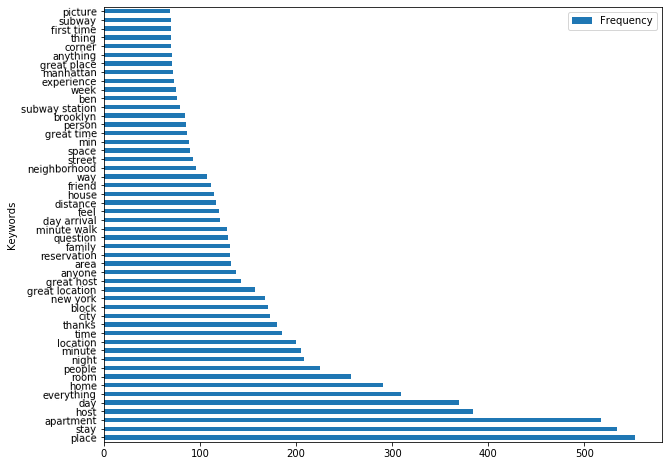

In [35]:
df_fDist = freqDistRDD.toDF() #converting RDD to spark dataframe
df_fDist.createOrReplaceTempView("keywordTable") 
df2 = spark.sql("SELECT _1 AS Keywords, _2 as Frequency from keywordTable limit 50") #renaming columns 
pandD = df2.toPandas() #converting spark dataframes to pandas dataframes
pandD.plot.barh(x='Keywords', y='Frequency', rot=1, figsize=(10,8))

###Word Cloud

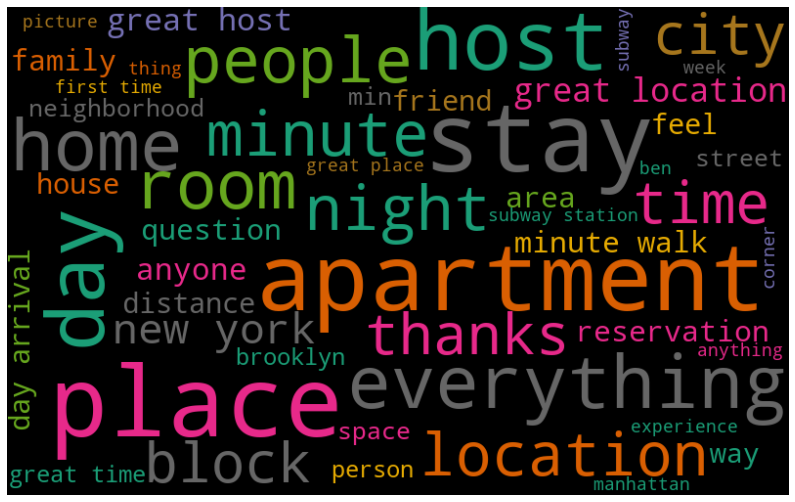

In [36]:
wordcloudConvertDF = pandD.set_index('Keywords').T.to_dict('records')
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=100, relative_scaling=0.5, colormap='Dark2').generate_from_frequencies(dict(*wordcloudConvertDF))
plt.figure(figsize=(14, 10))    
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()